In [85]:
import requests
import json
import csv
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow import config
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer
from keras.callbacks import EarlyStopping

In [86]:
config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Get the data from Binance api

## Get

In [87]:
# You can create 'api_key.txt' file with your api key inside it (it's already in '.gitignore')
# or just replace 'api_key.txt' => 'your_api_key'
api_key = open('api_key.txt', 'r').read()

endpoint = 'https://api.binance.com/api/v3/klines'

symbol =  'BTCUSDT'
interval =  '1h'
limit = 1000
headers = {
    'X-MBX-APIKEY': api_key
}

# Get current date, 4 years ago
start_time = int((time.time() - 126230400) * 1000) # 126230400 seconds = 4 years
end_time = int(time.time() * 1000)

results = []

# Loop through the data until there is no more left
while True:
    # Make the initial request with these parameters
    params = {'symbol': symbol, 'interval': interval, 'startTime': start_time, 'endTime': end_time, 'limit': limit}
    response = requests.get(endpoint, headers=headers, params=params)

    # Check if there is any data left
    if not response.json():
        break

    # Append the data to the results list
    results.extend(response.json())

    # Set the start time for the next request
    start_time = int(results[-1][0]) + 1


## Define dataframe columns and create datafile

In [88]:
columns = ['open_time', 'open_price', 'high_price', 'low_price',
            'close_price', 'Volume', 'close_time', 'quote_asset_volume',
            'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

df = pd.DataFrame(results, columns=columns)


In [89]:
df = df[['open_time', 'open_price']]

with open('data.csv', 'w') as file:
    file.write(df.to_csv())

In [90]:
df

,open_time,open_price
0,1555894800000,5256.92000000
1,1555898400000,5228.32000000
2,1555902000000,5224.50000000
3,1555905600000,5218.32000000
4,1555909200000,5237.26000000
...,...,...
35005,1682107200000,27279.90000000
35006,1682110800000,27270.87000000
35007,1682114400000,27279.99000000
35008,1682118000000,27266.07000000


# Preparing data

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35010 entries, 0 to 35009
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   open_time   35010 non-null  int64 
 1   open_price  35010 non-null  object
dtypes: int64(1), object(1)
memory usage: 547.2+ KB


### Split df to dates and prices

In [92]:
df_dates = df['open_time']
df_prices = df['open_price']

In [93]:
df_prices

0         5256.92000000
1         5228.32000000
2         5224.50000000
3         5218.32000000
4         5237.26000000
              ...      
35005    27279.90000000
35006    27270.87000000
35007    27279.99000000
35008    27266.07000000
35009    27262.84000000
Name: open_price, Length: 35010, dtype: object

### Change df_prices type from object to float

In [94]:
df_prices = df_prices.astype(float)

In [95]:
df_prices

0         5256.92
1         5228.32
2         5224.50
3         5218.32
4         5237.26
           ...   
35005    27279.90
35006    27270.87
35007    27279.99
35008    27266.07
35009    27262.84
Name: open_price, Length: 35010, dtype: float64

## Split into training, validation and test

In [96]:
train_valid_border = 0.65
valid_test_border = 0.75

train, valid, test = np.split(df_prices, [int(len(df_prices) * train_valid_border), int(len(df_prices) * valid_test_border)])

In [97]:
len(train), len(valid), len(test)

(22756, 3501, 8753)

# Scale

In [99]:
scaler = MinMaxScaler()

train_norm = scaler.fit_transform(train.values.reshape(-1, 1))
valid_norm = scaler.fit_transform(valid.values.reshape(-1, 1))
test_norm = scaler.fit_transform(test.values.reshape(-1, 1))

## Plot

Text(0, 0.5, 'Exchange rate BTC to USDT')

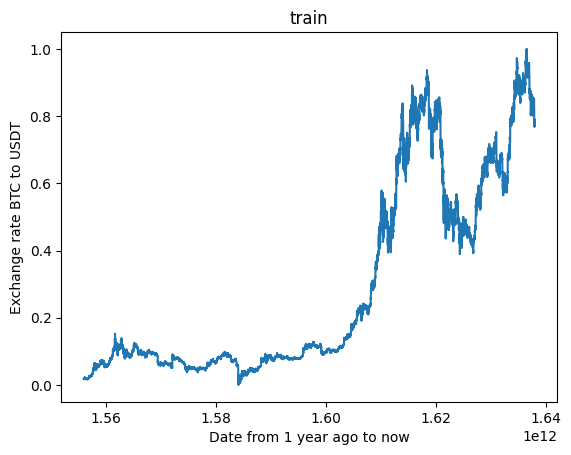

In [100]:
plt.plot(df_dates[:int(len(df_prices) * train_valid_border)], train_norm)
plt.title('train')
plt.xlabel('Date from 1 year ago to now')
plt.ylabel('Exchange rate BTC to USDT')

Text(0, 0.5, 'Exchange rate BTC to USDT')

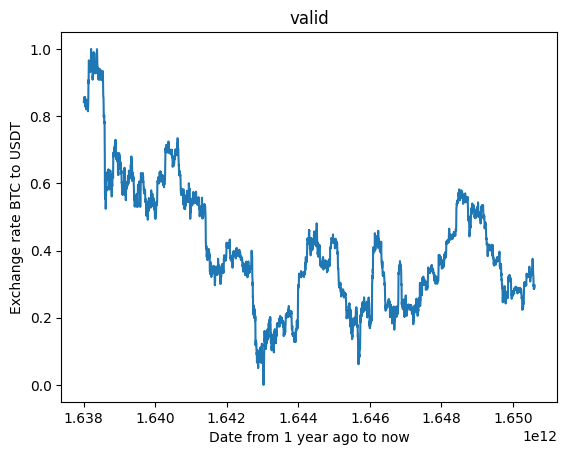

In [105]:
plt.plot(df_dates[int(len(df_prices) * train_valid_border):int(len(df_prices) * valid_test_border)], valid_norm)
plt.title('valid')
plt.xlabel('Date from 1 year ago to now')
plt.ylabel('Exchange rate BTC to USDT')

Text(0, 0.5, 'Exchange rate BTC to USDT')

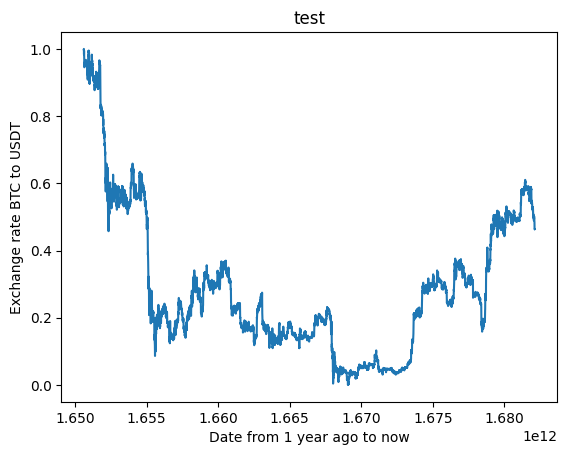

In [102]:
plt.plot(df_dates[int(len(df_prices) * valid_test_border):], test_norm)
plt.title('test')
plt.xlabel('Date from 1 year ago to now')
plt.ylabel('Exchange rate BTC to USDT')

# Arrays => X, y


In [113]:
look_back = 720 # x will be last 720 hours for each y

train_gen = TimeseriesGenerator(train_norm, train_norm, length=look_back, batch_size=100)
valid_gen = TimeseriesGenerator(valid_norm, valid_norm, length=look_back, batch_size=1)
test_gen = TimeseriesGenerator(test_norm, test_norm, length=look_back, batch_size=1)

print('Number of batches in train_gen:', train_gen.__len__())

Number of batches in train_gen: 221


### X for first batch in train_gen (as pd dataframe)

In [114]:
pd.DataFrame(train_gen.__getitem__(0)[0][...,0])

,0,1,2,3,4,5,6,7,8,9,...,710,711,712,713,714,715,716,717,718,719
0,0.017452,0.017008,0.016949,0.016853,0.017147,0.017108,0.017310,0.017246,0.017452,0.017598,...,0.059588,0.058615,0.058835,0.058355,0.058636,0.058738,0.058536,0.058135,0.058470,0.057772
1,0.017008,0.016949,0.016853,0.017147,0.017108,0.017310,0.017246,0.017452,0.017598,0.017856,...,0.058615,0.058835,0.058355,0.058636,0.058738,0.058536,0.058135,0.058470,0.057772,0.057853
2,0.016949,0.016853,0.017147,0.017108,0.017310,0.017246,0.017452,0.017598,0.017856,0.017732,...,0.058835,0.058355,0.058636,0.058738,0.058536,0.058135,0.058470,0.057772,0.057853,0.056922
3,0.016853,0.017147,0.017108,0.017310,0.017246,0.017452,0.017598,0.017856,0.017732,0.017773,...,0.058355,0.058636,0.058738,0.058536,0.058135,0.058470,0.057772,0.057853,0.056922,0.056453
4,0.017147,0.017108,0.017310,0.017246,0.017452,0.017598,0.017856,0.017732,0.017773,0.017616,...,0.058636,0.058738,0.058536,0.058135,0.058470,0.057772,0.057853,0.056922,0.056453,0.057612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.016886,0.017625,0.018275,0.019502,0.018784,0.018405,0.018505,0.018198,0.017998,0.018139,...,0.060334,0.060299,0.060037,0.059675,0.059432,0.059836,0.059459,0.059509,0.059509,0.059701
96,0.017625,0.018275,0.019502,0.018784,0.018405,0.018505,0.018198,0.017998,0.018139,0.018341,...,0.060299,0.060037,0.059675,0.059432,0.059836,0.059459,0.059509,0.059509,0.059701,0.059412
97,0.018275,0.019502,0.018784,0.018405,0.018505,0.018198,0.017998,0.018139,0.018341,0.018349,...,0.060037,0.059675,0.059432,0.059836,0.059459,0.059509,0.059509,0.059701,0.059412,0.059293
98,0.019502,0.018784,0.018405,0.018505,0.018198,0.017998,0.018139,0.018341,0.018349,0.018636,...,0.059675,0.059432,0.059836,0.059459,0.059509,0.059509,0.059701,0.059412,0.059293,0.058554


### y for first batch in train_gen (as pd dataframe)

In [116]:
pd.DataFrame(train_gen.__getitem__(0)[1])

,0
0,0.057853
1,0.056922
2,0.056453
3,0.057612
4,0.057783
...,...
95,0.059412
96,0.059293
97,0.058554
98,0.058868


# Training

In [118]:
data_dim = 1

model = Sequential()

model.add(InputLayer(input_shape=(look_back, data_dim)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))

early_stopping = EarlyStopping(patience=10)

model.compile('adam', loss='mae', metrics=['accuracy'])

model.fit_generator(train_gen, epochs=10, validation_data=valid_gen, callbacks=early_stopping)

Epoch 1/10


C:\Users\Evgeny\AppData\Local\Temp\ipykernel_7464\807885482.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, epochs=10, validation_data=valid_gen, callbacks=early_stopping)


221/221 [==============================] - 77s 341ms/step - loss: 0.0626 - accuracy: 0.2075 - val_loss: 0.0191 - val_accuracy: 0.0126
Epoch 2/10
221/221 [==============================] - 72s 326ms/step - loss: 0.0167 - accuracy: 0.1612 - val_loss: 0.0390 - val_accuracy: 0.0791
Epoch 3/10
221/221 [==============================] - 73s 331ms/step - loss: 0.0133 - accuracy: 0.3033 - val_loss: 0.0178 - val_accuracy: 0.0011
Epoch 4/10
221/221 [==============================] - 72s 326ms/step - loss: 0.0106 - accuracy: 0.1746 - val_loss: 0.0172 - val_accuracy: 0.0500
Epoch 5/10
221/221 [==============================] - 72s 327ms/step - loss: 0.0089 - accuracy: 0.1896 - val_loss: 0.0163 - val_accuracy: 7.1917e-04
Epoch 6/10
221/221 [==============================] - 72s 327ms/step - loss: 0.0071 - accuracy: 0.2350 - val_loss: 0.0154 - val_accuracy: 0.1093
Epoch 7/10
221/221 [==============================] - 72s 327ms/step - loss: 0.0083 - accuracy: 0.2707 - val_loss: 0.0146 - val_accuracy:

# 123456